/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7072851657867432
Epoch 2, Loss: 0.3586483299732208
Epoch 3, Loss: 0.17940574884414673
Epoch 4, Loss: 0.09267240762710571
Epoch 5, Loss: 0.04636172205209732
Epoch 6, Loss: 0.0285441055893898
Epoch 7, Loss: 0.01940128207206726
Epoch 8, Loss: 0.014283308759331703


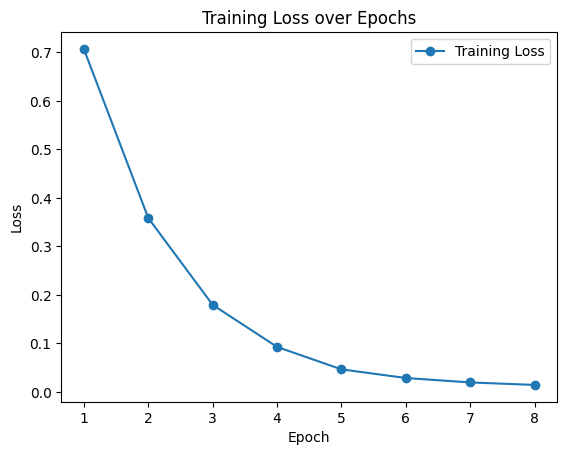

In [1]:
### Train simple model + Plot epoch loss

import os
import torch
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Custom dataset class
class ArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(self.labels['labels'].apply(lambda x: x.split(', ')))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.labels.iloc[idx, 1].split(', ')
        labels = self.mlb.transform([labels])[0]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset and DataLoader
train_dataset = ArtDataset(csv_file='dataset/labelsalgomix.csv', root_dir='dataset/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.mlb.classes_))

# Training
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

torch.save(model.state_dict(), 'art_model_algomix.pth')

plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [3]:
### RUN ART MODEL

import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from torchvision import transforms

# Load the fine-tuned model
model.load_state_dict(torch.load('art_model_algomix.pth'))
model.eval()

# Load CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device)

# Define the same transform used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load your CSV file
df = pd.read_csv('dataset/labelsalgomix.csv')

# Initialize an empty dictionary to hold your keyword-to-algorithm mappings
keyword_to_algo = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    labels = [label.strip().lower() for label in row['labels'].split(", ")]
    algorithm = labels[0]  # Assuming the first label is always the algorithm

    # Map each label to the algorithm
    for label in labels:
        keyword_to_algo[label] = algorithm


# Function to predict and verify descriptions
def predict_and_verify(image_path, model, clip_model, clip_processor, mlb, keyword_to_algo):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    
    # Preprocess the image for the classification model
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Predict keywords
    with torch.no_grad():
        output = model(input_image)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        top_indices = probs.argsort()[-5:][::-1]  # Top 5 keywords
        keywords = [mlb.classes_[idx] for idx in top_indices]
    
    # Preprocess the image for CLIP
    clip_image_input = clip_processor(image).unsqueeze(0).to(device)
    
    # Encode image and generated keywords with CLIP
    text_inputs = torch.cat([clip.tokenize(keyword) for keyword in keywords]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_image_input)
        text_features = clip_model.encode_text(text_inputs)
    
    # Compute similarities
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]
    
    # Refine and return top keywords
    refined_keywords = sorted(zip(keywords, similarities), key=lambda x: x[1], reverse=True)[:5]
    top_keywords = [kw[0] for kw in refined_keywords]
    
    # Map keywords to algorithms
    algorithm_count = {}
    for keyword in top_keywords:
        keyword_lower = keyword.lower()
        algorithm = keyword_to_algo.get(keyword_lower, None)
        if algorithm:
            if algorithm in algorithm_count:
                algorithm_count[algorithm] += 1
            else:
                algorithm_count[algorithm] = 1

    # Choose the algorithm that appears most frequently
    if algorithm_count:
        final_algorithm = max(algorithm_count, key=algorithm_count.get)
    else:
        final_algorithm = None

    return top_keywords, final_algorithm

# Example usage
image_path = "image32.png"
keywords, algorithm = predict_and_verify(image_path, model, clip_model, clip_preprocess, train_dataset.mlb, keyword_to_algo)

print("Predicted Keywords:", keywords)
print("Mapped Algorithm:", algorithm)


Predicted Keywords: ['mandelbrot', 'fractal', 'pattern', 'symetric', 'flowers']
Mapped Algorithm: mandelbrot
